In [165]:
import numpy as np
import torch 
import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
from generators.generators import ARMA, GARCH11, Noise
from generators.ESN import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kernel calls test

In [166]:
# Set parameters
M_train = 50    # Number of training samples (collection of samples from a given mean reversion parameter)
M_test  = 10    # Number of test samples
N       = 20    # Number of path per sample (with the same distribution)
length  = 200   # Length of each path (time steps)

time_steps = np.linspace(0, 1, length+1)
max_T      = 1
min_T      = 1e-6

# Pick target (parameter to regress) from ['mean_rev', 'vol', 'hurst']
targets = ['mean_rev', 'vol', 'hurst']
target = targets[0]

In [167]:
# FBM for OU process (need to install to euler environment)
from fbm import FBM

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def fOU_generator(a,n=0.3,h=0.2,length=300):
    '''
    Generate a fractional Ornstein-Uhlenbeck process using the following SDE:
    dX_t = -a*(X_t - m)dt + n*dW_t
    where W_t is a fractional Brownian motion with Hurst parameter H = h.

    Arguments:
    a (float): Mean reversion speed
    n (float): Volatility
    h (float): Hurst parameter
    length (int): Length of the process

    Returns:
    np.array: Fractional Ornstein-Uhlenbeck process
    
    '''
    
    fbm_increments = np.diff(FBM(length, h).fbm())
    x0 = np.random.normal(1,0.1)
    x0 = 0.5
    m = x0
    price = [x0]
    for i in range(length):
        p = price[i] - a*(price[i]-m) + n*fbm_increments[i]
        price.append(p)
    return np.array(price)


def generate_process_dat_fOU(N, M, length, time_steps, max_T = 1e0, min_T = 1e-6, n = 0.3, h = 0.2, a=0.5, target = 'mean_rev'):
    '''
    Generate M samples of N paths of a fractional Ornstein-Uhlenbeck process using the following SDE:
    dX_t = -a*(X_t - m)dt + n*dW_t
    where W_t is a fractional Brownian motion with Hurst parameter H = h.
    where a is drawn from a uniform distribution between max_T and min_T and is the target variable.

    Arguments:
        N (int): Number of paths
        M (int): Number of samples
        length (int): Length of the process
        time_steps (np.array): Time steps
        max_T (float): Maximum value of the mean reversion
        min_T (float): Minimum value of the mean reversion
        n (float): Volatility
        h (float): Hurst parameter
        a (float): Mean reversion speed
        target (str): Target variable to predict ['mean_rev', 'vol', 'hurst'] (generates paths based on these variables)

    Returns:
        torch.Tensor: Scaled and formatted paths of the fractional Ornstein-Uhlenbeck process
        torch.Tensor: Mean reversion/volatility/hurst values

    '''
    assert target in ['mean_rev', 'vol', 'hurst'], "Target must be either 'mean_rev', 'vol' or 'hurst'"

    if target == 'mean_rev':
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(scale,n,h,length))
    elif target == 'vol':
        max_T = 0.8
        min_T = 0.1
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(a,scale,h,length))
    elif target == 'hurst':
        max_T = 0.8
        min_T = 0.1
        y = np.array((max_T-min_T)*np.random.rand(M)+min_T)
        X = np.zeros((M, N, length+1))
        for i, scale in enumerate(y):
            for j in range(N):
                X[i,j] = np.exp(fOU_generator(a,n,scale,length))

    # Ensure uniform shape for stacking
    X = np.array([np.array(intermediate) for intermediate in X])  # Shape: [M, N, length, 1]

    # Validate dimensions
    if not all(arr.shape == X[0][0].shape for sample in X for arr in sample):
        raise ValueError("All paths must have the same shape.")
    
    # Prepare time steps
    time_steps_repeated = np.tile(time_steps, (M, N, 1))  # Shape: [M, N, length]

    # Stack time steps and scaled paths
    X_stacked = np.stack([time_steps_repeated, X], axis=-1)  # Shape: [M, N, length, 2]

    # Convert to PyTorch tensor
    X_tensor = torch.tensor(X_stacked, dtype=torch.float64)
    y_tensor = torch.tensor(y, dtype=torch.float64)

    # Print final shape
    print("Final X shape:", X_tensor.shape,"Final y shape:", y_tensor.shape) 

    return X_tensor, y_tensor

In [168]:
np.random.seed(0)
X_train, y_train = generate_process_dat_fOU(N, M_train, length, time_steps, max_T = 1e0-min_T, min_T = 1e-6, 
                                            n = 0.3, h = 0.2, a = 0.5, target = target)

Final X shape: torch.Size([50, 20, 201, 2]) Final y shape: torch.Size([50])


In [169]:
# Get signature kernel

static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels           = 10 # number of levels in the truncated signature kernel
kernel_sigma       = 1e-6 # bandwidth parameter for the static kernel

kwargs = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': kernel_sigma,
}

# Define the signature kernel
signature_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs)

In [170]:
X_train = X_train[..., 1:]
# X_train = X_train.permute(0, 1, 2, 3)  # shape is [50, 20, 201, 1]
X_train.shape

torch.Size([50, 20, 201, 1])

In [171]:
sigma = 1.0

# Specify the static kernel 
static_kernel = ksig_pde.RBFKernel(sigma=sigma)

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

print(X_train[0].shape, X_train[1].shape)

# Compute the signature kernel
mat1 = signature_kernel(X_train[0], X_train[1])
mat2 = sig_pde_kernel.compute_Gram(X_train[0], X_train[1])
print("signature_kernel shape:", mat1.shape)
print("sig_pde_kernel shape:", mat2.shape)
print("Absolute difference sum:", torch.abs(mat1 - mat2).sum().item())

torch.Size([20, 201, 1]) torch.Size([20, 201, 1])
signature_kernel shape: torch.Size([20, 20])
sig_pde_kernel shape: torch.Size([20, 20])
Absolute difference sum: 520.7064078777371


In [172]:
# Compute the static kernel Gram matrix between X_train[0] and X_train[1]
# Use the static_kernel defined earlier (RBFKernel)

static_gram = ksig_disc.kernels.RBFKernel(sigma=sigma)(X_train[0].reshape(X_train[0].shape[0], -1), X_train[1].reshape(X_train[1].shape[0], -1))
print("Static kernel Gram matrix shape:", static_gram.shape)


Static kernel Gram matrix shape: torch.Size([20, 20])


In [173]:
mat2

tensor([[1.0221, 1.0016, 1.0329, 1.0860, 1.0730, 1.0451, 1.0431, 1.0758, 1.0850,
         1.0821, 1.0613, 1.1020, 1.0262, 1.0414, 1.0746, 1.0605, 1.0524, 1.1128,
         1.0622, 1.0287],
        [1.0375, 1.0224, 1.0488, 1.1078, 1.0986, 1.0631, 1.0703, 1.0897, 1.1029,
         1.1079, 1.0798, 1.1194, 1.0397, 1.0655, 1.1104, 1.0851, 1.0763, 1.1390,
         1.0844, 1.0541],
        [1.0296, 1.1192, 0.9791, 0.9677, 1.0146, 0.9597, 1.1561, 0.9806, 0.9811,
         1.0760, 1.0799, 0.9415, 0.9648, 1.1140, 1.1689, 1.0614, 1.0982, 1.0519,
         1.0032, 1.0840],
        [1.0484, 1.1099, 1.0124, 1.0708, 1.0905, 1.0107, 1.1524, 1.0653, 1.0799,
         1.1425, 1.1417, 1.0531, 1.0169, 1.1227, 1.2108, 1.1066, 1.1426, 1.1495,
         1.0684, 1.0971],
        [1.0446, 1.1011, 1.0181, 1.0595, 1.0816, 1.0157, 1.1640, 1.0537, 1.0685,
         1.1406, 1.1176, 1.0379, 1.0089, 1.1330, 1.2027, 1.1021, 1.1200, 1.1400,
         1.0662, 1.0942],
        [1.0442, 1.0884, 1.0274, 1.0437, 1.0677, 1.0173, 1.1

# Generator test

In [174]:
torch.manual_seed(0)

x_ar = ARMA(T=100, p=2, q=0, phi=[0.7, -0.2]).generate(N=5, noise=Noise("normal"))
x_ma = ARMA(T=100, p=0, q=2, theta=[0.5, 0.2]).generate(N=5, noise=Noise("t", {"df": 7}))
x_arma = ARMA(T=100, p=2, q=1, phi=[0.7, -0.2], theta=[0.5]).generate(N=5, noise=Noise("normal"))
x_g  = GARCH11(T=200, omega=0.05, alpha=0.08, beta=0.9).generate(N=3, noise=Noise("normal"))

print(x_ar.shape, x_ma.shape, x_arma.shape, x_g.shape)

torch.Size([5, 100, 1]) torch.Size([5, 100, 1]) torch.Size([5, 100, 1]) torch.Size([3, 200, 1])


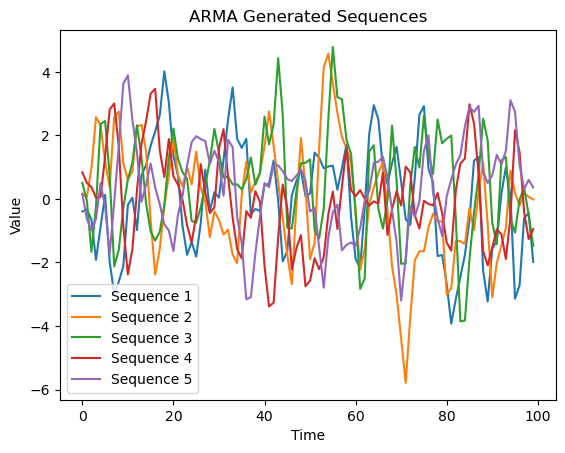

In [175]:
import matplotlib.pyplot as plt

for i in range(x_arma.shape[0]):
    plt.plot(x_arma[i].squeeze().numpy(), label=f'Sequence {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA Generated Sequences')
plt.legend()
plt.show()

# ESN

In [176]:
h, m, d = 500, 20, 1
A = 0.9 * torch.randn(h, h) / (h ** 0.5)
C = torch.randn(h, m) / (m ** 0.5)

gen = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)
Z = gen(T=200, N=2)  
print(Z.shape)

torch.Size([2, 200, 1])


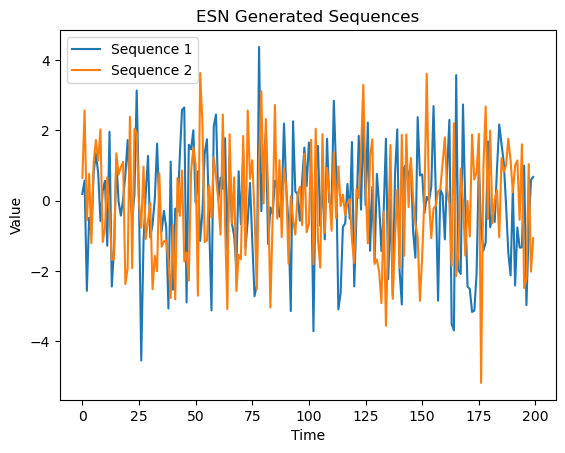

In [177]:
import matplotlib.pyplot as plt

for i in range(Z.shape[0]):
    plt.plot(Z[i].detach().squeeze().numpy(), label=f'Sequence {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ESN Generated Sequences')
plt.legend()
plt.show()

example learning

In [178]:
def rbf_mmd2(x, y, sigma=1.0):
    # x,y: (B, T, d) or (B, D) after flattening
    x = x.reshape(x.shape[0], -1)
    y = y.reshape(y.shape[0], -1)

    xx = (x[:, None, :] - x[None, :, :]).pow(2).sum(-1)
    yy = (y[:, None, :] - y[None, :, :]).pow(2).sum(-1)
    xy = (x[:, None, :] - y[None, :, :]).pow(2).sum(-1)

    kxx = torch.exp(-xx / (2 * sigma**2))
    kyy = torch.exp(-yy / (2 * sigma**2))
    kxy = torch.exp(-xy / (2 * sigma**2))

    return kxx.mean() + kyy.mean() - 2 * kxy.mean()


# fixed reservoir
h, m, d = 300, 20, 1
A = torch.randn(h, h) / (h ** 0.5)
C = torch.randn(h, m) / (m ** 0.5)

gen = ESNGenerator(A, C, out_dim=d, target_rho=0.9, xi_scale=1.0, eta_scale=0.1)
opt = torch.optim.Adam([gen.W], lr=1e-3)

T = 128
for step in range(2000):
    # real batch (example placeholder)
    Y = torch.randn(64, T, d, device=gen.A.device, dtype=gen.A.dtype)

    # fake batch
    Z = gen(T=T, N=Y.shape[0])  # (N,T,d)

    loss = rbf_mmd2(Z, Y, sigma=10.0)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % 200 == 0:
        print(step, float(loss))


0 0.058554887771606445
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/omerdoruksuder/anaconda3/envs/master-thesis/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_64533/3496979362.py", line 31, in <module>
    Z = gen(T=T, N=Y.shape[0])  # (N,T,d)
        ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omerdoruksuder/anaconda3/envs/master-thesis/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omerdoruksuder/anaconda3/envs/master-thesis/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omerdoruksuder/Desktop/NTU/RESEARCH/_github_repos/My_trial_space/generators/ESN.py", line None, in forwar